<a href="https://colab.research.google.com/github/DPK-VT/MLTESTS/blob/main/Copy_of_Currency_ECBTest6_W180_15days%20w%20chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
143/143 - 15s - 103ms/step - loss: 0.0390 - val_loss: 5.3723e-04 - learning_rate: 1.0000e-03
Epoch 2/100
143/143 - 20s - 137ms/step - loss: 0.0081 - val_loss: 6.3738e-04 - learning_rate: 1.0000e-03
Epoch 3/100
143/143 - 20s - 140ms/step - loss: 0.0061 - val_loss: 6.5588e-04 - learning_rate: 1.0000e-03
Epoch 4/100
143/143 - 21s - 145ms/step - loss: 0.0048 - val_loss: 3.8645e-04 - learning_rate: 1.0000e-03
Epoch 5/100
143/143 - 12s - 85ms/step - loss: 0.0042 - val_loss: 7.1184e-04 - learning_rate: 1.0000e-03
Epoch 6/100
143/143 - 21s - 146ms/step - loss: 0.0036 - val_loss: 4.3122e-04 - learning_rate: 1.0000e-03
Epoch 7/100
143/143 - 21s - 145ms/step - loss: 0.0034 - val_loss: 3.3301e-04 - learning_rate: 1.0000e-03
Epoch 8/100
143/143 - 20s - 137ms/step - loss: 0.0031 - val_loss: 3.7801e-04 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
143/143 - 12s - 84ms/step - loss: 0.0029 - val_loss: 3.9685e-04 - learni

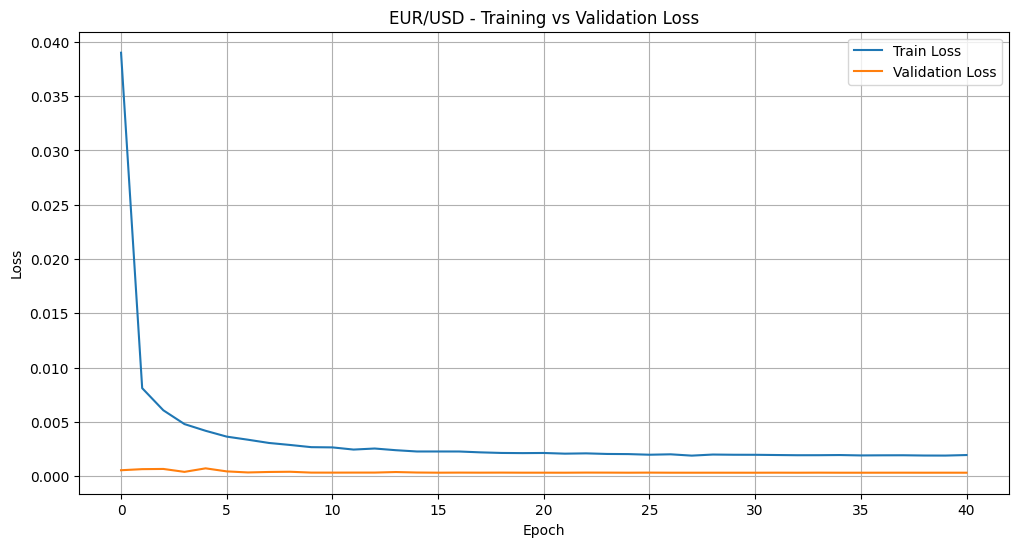

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Evaluation for EUR/USD
RMSE: 0.0136
MAE : 0.0102


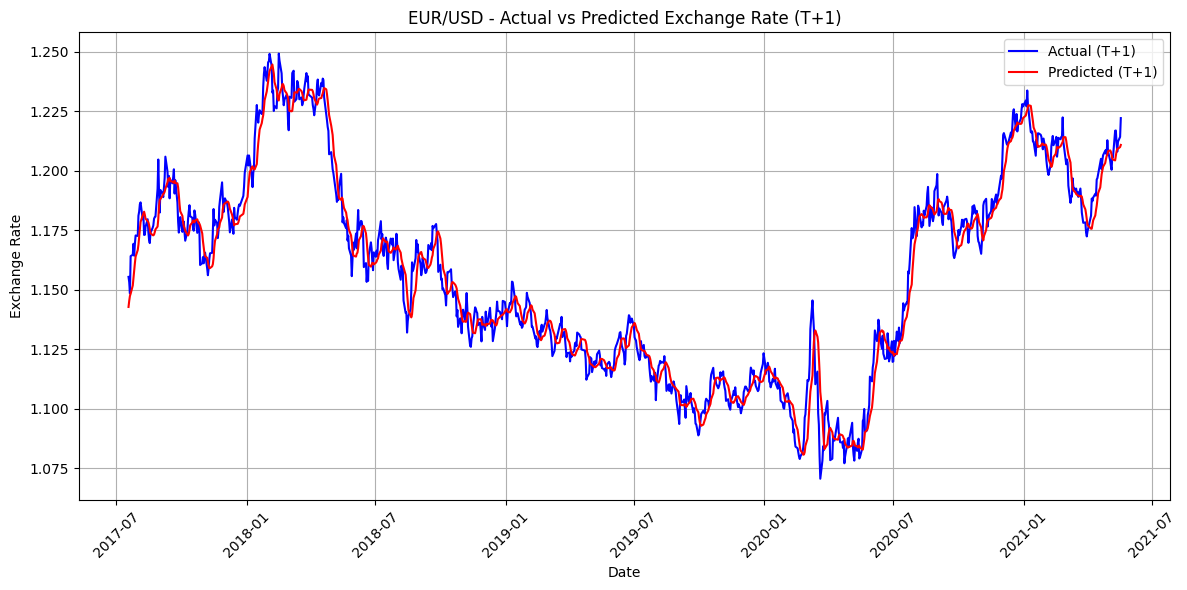

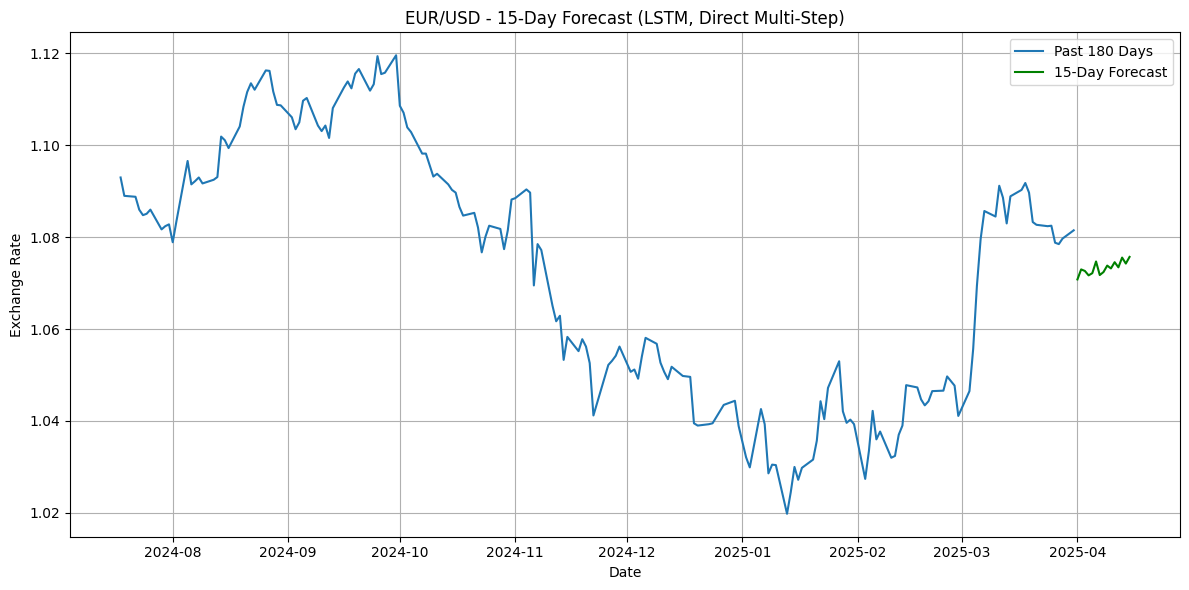

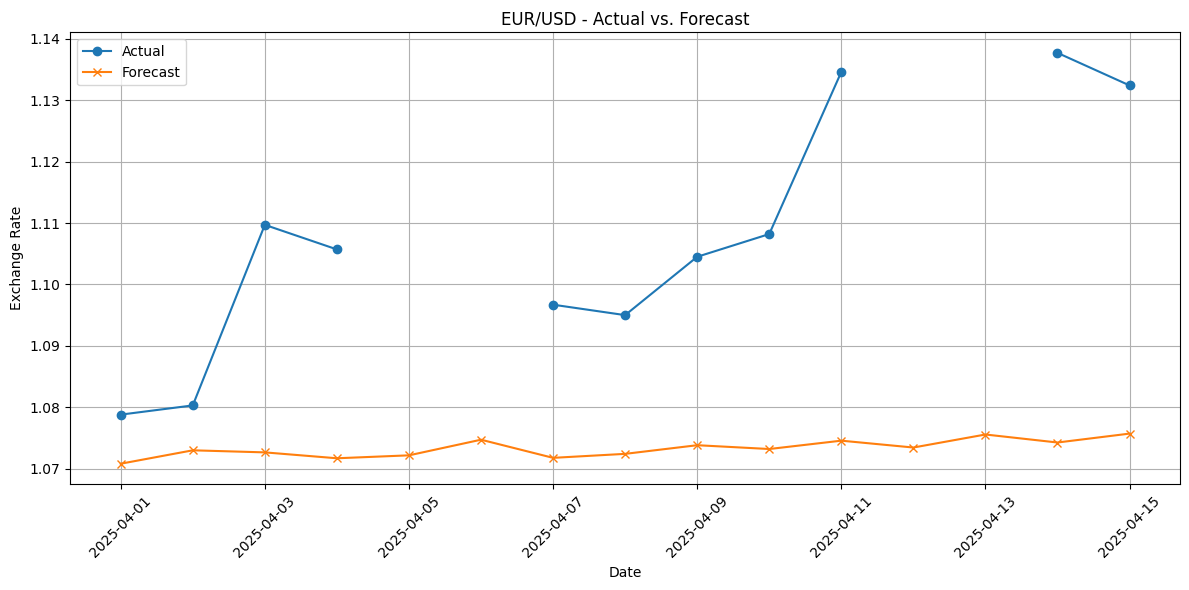

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from tabulate import tabulate
from pandas.tseries.offsets import BDay

# create times series sequence for multi step forecasting
def create_sequences_multi_output(data, window_size, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

# Parameters
window_size = 180 #days
forecast_horizon = 15 #days to be forecasted
currency = 'EUR/USD'  # can change this to test other currencies pairs in file

#Load and preprocess the data (ECB exchange rates)
data = pd.read_excel("ECB_exchange_rates_march31.xlsx", index_col="Date", parse_dates=True)
df = data[[currency]].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

#Create sequences
X, y = create_sequences_multi_output(scaled_data, window_size, forecast_horizon)

#Split the data for trainiong and testing, 70% training, 15% test, 15% validation
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

#Reshape the shape the data for LSTM model
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_val = X_val.reshape((X_val.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

#Define teh LSTM model
model = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(forecast_horizon)
])
model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping and learning rate adjustments
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

#Generated forecast for future values
forecast_input = X_test[-1].reshape(1, window_size, 1)
forecast = model.predict(forecast_input)[0]  #shape is per forcast_horizon
forecast = scaler.inverse_transform(forecast.reshape(-1, 1))

#Generate dates for teh forecast
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon)


#Save the trained model and scaler
model.save(f"{currency.replace('/', '_')}_lstm_model.keras")
joblib.dump(scaler, f"{currency.replace('/', '_')}_scaler.pkl")

#Evaluation and Visualization for training/validation/forecast

#Create chart for training/validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{currency} - Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#Reshape the FX rate predictions and actuals to original scale
val_predictions = model.predict(X_val)
predictions_inv = scaler.inverse_transform(val_predictions.reshape(-1, 1))
actual_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

# Extract T+1 predictions and actuals
val_predictions_t1 = scaler.inverse_transform(val_predictions[:, [0]])
actual_t1 = scaler.inverse_transform(y_val[:, 0].reshape(-1, 1))

# Create corresponding date range for the validation set
# Step 1: Determine where the y_val sequences start in the original DataFrame
val_start_index = window_size + train_size  # Index in df where y_val starts
val_dates = df.index[val_start_index:val_start_index + len(y_val)]

# Calculate RMSE and MAE for forecast
rmse = np.sqrt(mean_squared_error(actual_inv.flatten(), predictions_inv.flatten()))
mae = mean_absolute_error(actual_inv.flatten(), predictions_inv.flatten())
print(f"\nEvaluation for {currency}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# Create chart for first forecast step (T+1)
#plt.figure(figsize=(12, 6))
#plt.plot(actual_inv[:, 0], label='Actual (T+1)', color='blue')
#plt.plot(predictions_inv[:, 0], label='Predicted (T+1)', color='red')
#plt.title(f'{currency} - Actual vs Predicted Exchange Rate (T+1)')
#plt.xlabel('Sample Index')
#plt.ylabel('Exchange Rate')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(12, 6))
plt.plot(val_dates, actual_t1.flatten(), label='Actual (T+1)', color='blue')
plt.plot(val_dates, val_predictions_t1.flatten(), label='Predicted (T+1)', color='red')
plt.title(f'{currency} - Actual vs Predicted Exchange Rate (T+1)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Plot forecast ---
plt.figure(figsize=(12, 6))
plt.plot(df.index[-180:], df[currency].values[-180:], label='Past 180 Days')
plt.plot(future_dates, forecast.flatten(), label='15-Day Forecast', color='green')
plt.title(f"{currency} - 15-Day Forecast (LSTM, Direct Multi-Step)")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Load actual rates from Excel ---
actual_rates_file = "ECB_exchange_rates_April-15days.xlsx"  # Replace with your actual rates file
actual_rates_df = pd.read_excel(actual_rates_file, index_col="Date", parse_dates=True)

# Ensure the currency column exists in the actual rates file
if currency not in actual_rates_df.columns:
    raise ValueError(f"Currency '{currency}' not found in actual rates file.")

# --- Align dates and handle potential mismatches ---
# Reindex the actual_rates_df to match future_dates
actual_rates_df = actual_rates_df.reindex(future_dates)

# Get the actual rates for the forecast period, handling NaNs
past_15_days_actual = actual_rates_df[currency].values  # Access the currency column

# --- Create and display the chart ---
plt.figure(figsize=(12, 6))
plt.plot(future_dates, past_15_days_actual.flatten(), label='Actual', marker='o')  # Plot actual values
plt.plot(future_dates, forecast.flatten(), label='Forecast', marker='x')  # Plot forecast values
plt.title(f"{currency} - Actual vs. Forecast")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()